In [16]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
!pip install quandl 
!pip install yfinance --upgrade --no-cache-dir
import pandas as pd
import quandl
import yfinance as yf
import numpy as np
import requests
import matplotlib.pyplot as plt



# Function for the api request to get the data from td ameritrade
def us_hist_request(stock):
    """
    Makes an api call for a list of stock symbols
    and returns a dataframe
    """
    td_api_key = r"PZBFTNFXZAI6GCTYUGDBUDBDFSUKJXQK"
    url = r"https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format(stock)

    params = {
        'apikey': td_api_key,
        'periodType': 'year',
        'period': '5',
        'frequencyType': 'daily',
        'frequency': '1',
        'needExtendedHoursData': 'true'
    }

    request = requests.get(
        url=url,
        params=params
    ).json()


    try:
        df = pd.DataFrame(request['candles'])


        df.set_index('datetime', inplace=True)
        df.index = pd.to_datetime(df.index, unit='ms').date
        return df
    except:
        print("ERROR in TD AMERITRADE API CALL")
        print(request)


def hk_hist_request(stock):
    quandl.ApiConfig.api_key = r"j2QGEgPyPhe-dGsNNtzE"
    return quandl.get(f"HKEX/{stock}")

def fx_hist_request(fx_sym):
    fx = yf.Ticker(fx_sym)
    return fx.history(period="max")

us_li = ['ARKK', 'CGW', 'TSM', 'VOOV']
hk_li = ['02823', '02834']
fx_li = ["USDHKD=X", "HKDGBP=X"]


execution_date = "2021-04-08"

df_us = pd.concat([us_hist_request(us_sym)['close'].rename(us_sym) for us_sym in us_li], axis=1)
df_hk = pd.concat([hk_hist_request(hk_sym)['Nominal Price'].rename(hk_sym) for hk_sym in hk_li], axis=1)
df_fx = pd.concat([fx_hist_request(fx_sym)['Close'].rename(fx_sym.split('=')[0]) for fx_sym in fx_li], axis=1)[execution_date:]

port_prices = df_us.sort_index().merge(df_hk, how='left', left_index=True, right_index=True)[
    ['02823', '02834','ARKK', 'CGW', 'TSM', 'VOOV']].ffill()

execution_date_plus_one = "2021-04-09"
port_prices = port_prices[execution_date_plus_one:]
## need to correct close price on execution date with execution price
port_prices.loc[pd.to_datetime('2021-04-08'),['02823', '02834','ARKK', 'CGW', 'TSM','VOOV']] = [19.65, 258, 122.51, 50.23, 121.57, 138.47]
port_prices.loc[pd.to_datetime('2021-05-07'), 'ARKK'] = 112.08
port_prices.loc[pd.to_datetime('2021-05-18'), 'VOOV'] = 145

port_prices['usd'] = 1

port_prices.sort_index(inplace=True)

port_volume = pd.DataFrame([[3300, 300, 48, 202, 60, 0]]*port_prices.shape[0], 
                           columns=['02823', '02834','ARKK', 'CGW', 'TSM', 'VOOV'],
                          index=port_prices.index)

port_volume.loc['2021-05-07':, 'ARKK'] = 0
port_volume.loc['2021-05-18':, 'VOOV'] = 41

port_volume.loc['2021-05-07':'2021-05-17':, 'usd'] = 112.08 * 48



port_volume.fillna(0, inplace=True)


port_val = port_prices * port_volume

us_li = ['ARKK', 'CGW', 'TSM', 'VOOV', 'usd']

for us_sym in us_li:      
    port_val[us_sym] = port_val[us_sym]* df_fx['USDHKD']
    

port_val['hkd_val'] = port_val[us_li + hk_li].sum(axis=1)
port_val['gbp_val'] = port_val['hkd_val']*df_fx['HKDGBP']

port_val['gbp_ret'] = port_val['gbp_val'].pct_change(1)
port_val['gbp_cumret'] = (port_val['gbp_ret'].fillna(0)+1).cumprod()



## Portfolio Statistics

window = 126
def dd(ts):
  return np.min(ts/np.maximum.accumulate(ts)) -1 

port_val['max_dd'] = port_val['gbp_val'].rolling(window, min_periods=1).apply(dd)

port_val['SPY (GBP)'] = us_hist_request('SPY')['close'] * df_fx['USDHKD'] * df_fx['HKDGBP']


port_stats = pd.Series({'annu Sharpe': np.sqrt(252) *port_val['gbp_ret'].mean() / port_val['gbp_ret'].std(),
                        'curr PnL (GBP)': port_val['gbp_val'][-1] - port_val['gbp_val'][0],
                        'curr PnL (cum ret)': port_val['gbp_cumret'][-1] - 1,
                        r'SP 500 Benchmark (cum ret GBP)': (port_val[r'SPY (GBP)'].iloc[-1] / port_val[r'SPY (GBP)'].iloc[0]) - 1,
                        'Max DD': np.min(port_val['max_dd']),
                        'daily avg ret': port_val['gbp_ret'].mean(),
                        'daily avg ret (GBP)': port_val['gbp_ret'].mean()* port_val['gbp_val'][-1],
                        'daily vol': port_val['gbp_ret'].std(),
                        'daily vol (GBP)': port_val['gbp_ret'].std()* port_val['gbp_val'][-1],
                        'daily_skew': port_val['gbp_ret'].skew()
                        })



Requirement already up-to-date: yfinance in /Users/kingf.wong/anaconda3/envs/FinanceML2/lib/python3.7/site-packages (0.1.63)


In [18]:
port_stats.rename('Portfolio Stats').to_frame()

,Portfolio Stats
annu Sharpe,0.717132
curr PnL (GBP),831.412882
curr PnL (cum ret),0.027472
SP 500 Benchmark (cum ret GBP),0.068736
Max DD,-0.069127
daily avg ret,0.000353
daily avg ret (GBP),10.970936
daily vol,0.007810
daily vol (GBP),242.853896
daily_skew,-0.009127


In [19]:

((port_prices['2021-04-08':].pct_change().fillna(0)+1).cumprod() -1).iloc[-1].sort_values(ascending=False).rename(None, axis=1).rename('Assets Cumulative Returns').to_frame()

,Assets Cumulative Returns
CGW,0.153096
02834,0.103488
VOOV,0.048025
ARKK,0.004081
usd,0.000000
TSM,-0.027638
02823,-0.090076


In [20]:

port_val[['02823', '02834','ARKK', 'CGW', 'TSM', 'VOOV']].div(port_val['hkd_val'], axis=0).iloc[-1].rename(None, axis=1).sort_values(ascending=False).rename('Current Portfolio Weight').to_frame()

,Current Portfolio Weight
CGW,0.270122
02834,0.253578
02823,0.175180
TSM,0.163751
VOOV,0.137370
ARKK,0.000000


In [21]:
pd.DataFrame.from_dict({'sym':['02823', '02834','ARKK', 'CGW', 'TSM', 'VOOV'],
             'name':['iShares FTSE China A50 ETF (HKD)', 
                      'iShares NASDAQ 100 ETF (HKD)', 
                      'ARKK',
                      'Invesco S&P Global Water Index ETF',
                      'Taiwan Semiconductor Mfg. Co. Ltd.',
                      'Vanguard S&P 500 Value Index Fund ETF']}
                      ).set_index('sym')

,name
sym,
02823,iShares FTSE China A50 ETF (HKD)
02834,iShares NASDAQ 100 ETF (HKD)
ARKK,ARKK
CGW,Invesco S&P Global Water Index ETF
TSM,Taiwan Semiconductor Mfg. Co. Ltd.
VOOV,Vanguard S&P 500 Value Index Fund ETF


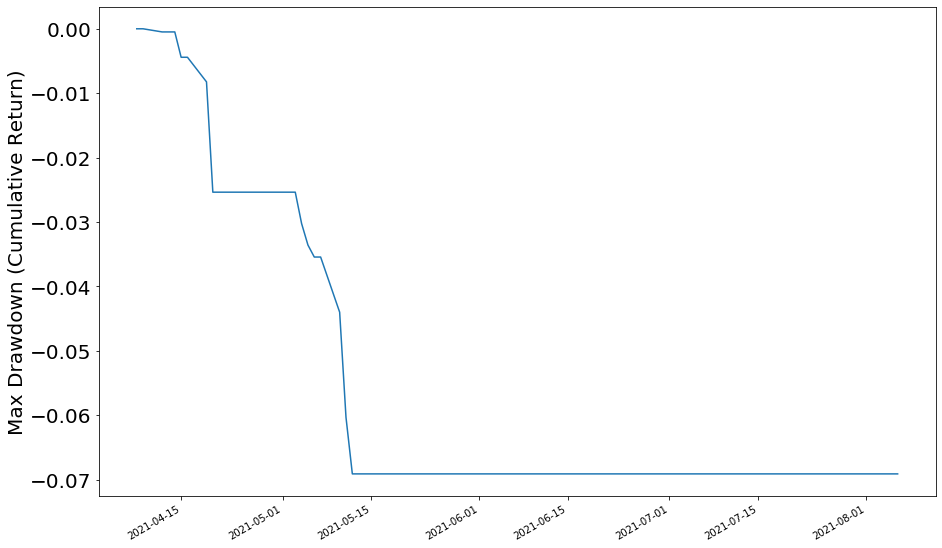

In [22]:
max_dd_ax = port_val['max_dd'].plot(figsize=(15,10))
max_dd_ax.set_ylabel("Max Drawdown (Cumulative Return)", fontsize=20)
plt.yticks(fontsize=20)
plt.show()

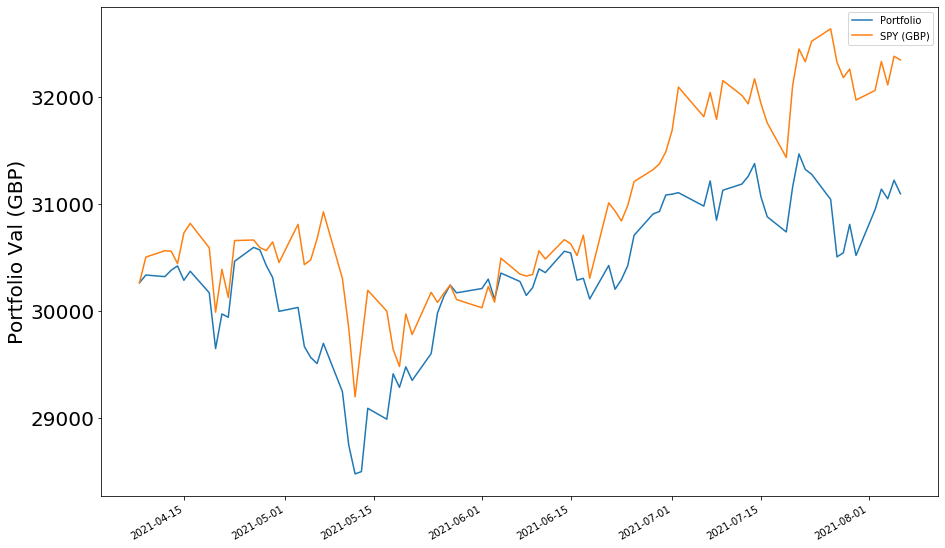

In [23]:
gbp_ax = port_val['gbp_val'].rename('Portfolio').plot(figsize=(15,10), legend='Portfolio')

((port_val[r'SPY (GBP)'].pct_change(1).fillna(0) +1).cumprod() * (port_val['gbp_val'].iloc[0])).plot(ax=gbp_ax, legend='SPY (GBP)')
gbp_ax.set_ylabel("Portfolio Val (GBP)", fontsize=20)
plt.yticks(fontsize=20)
plt.show()

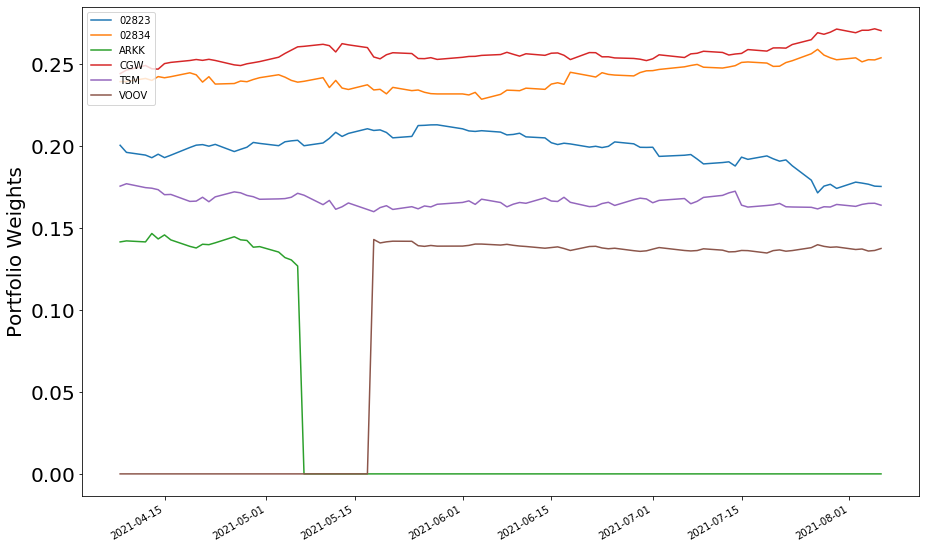

In [24]:
## HKD Portfolio Value
# hkd_ax = port_val['hkd_val'].plot(figsize=(15,10))
# hkd_ax.set_ylabel("Portfolio Val (HKD)", fontsize=20)
# plt.yticks(fontsize=20)
# plt.show()


## Portfolio Weight
port_weights = port_val[['02823', '02834','ARKK', 'CGW', 'TSM', 'VOOV']].div(port_val['hkd_val'], axis=0).plot(figsize=(15,10))
port_weights.set_ylabel('Portfolio Weights', fontsize=20)
port_weights.legend(loc=2)
_=plt.yticks(fontsize=20)


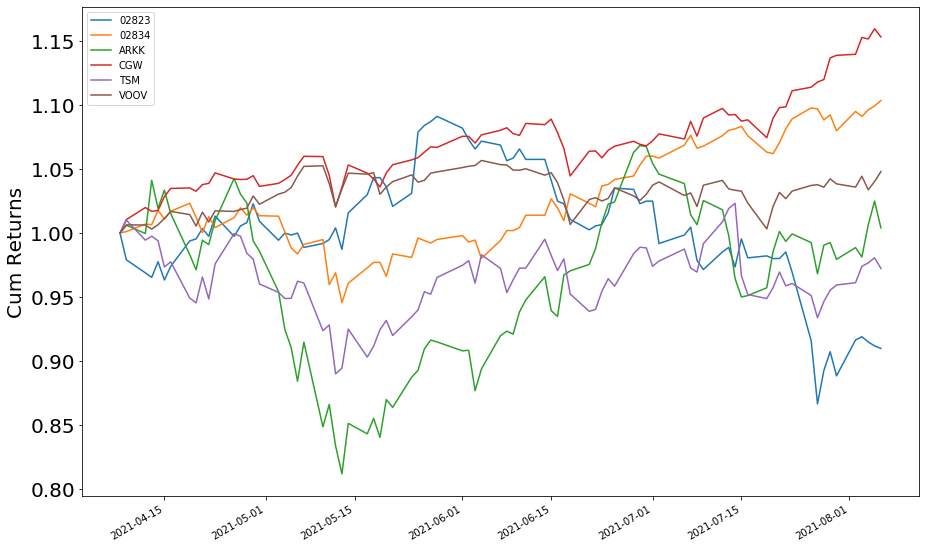

In [25]:
hist_cumret = (port_prices[['02823', '02834','ARKK', 'CGW', 'TSM', 'VOOV']]['2021-04-08':].pct_change().fillna(0)+1).cumprod()
etfs_ret_ax = hist_cumret.plot(figsize=(15,10))
etfs_ret_ax.set_ylabel('Cum Returns', fontsize=20)
_= plt.yticks(fontsize=20)

Current HKDGBP Returns (GBP/ HKD): -0.01228


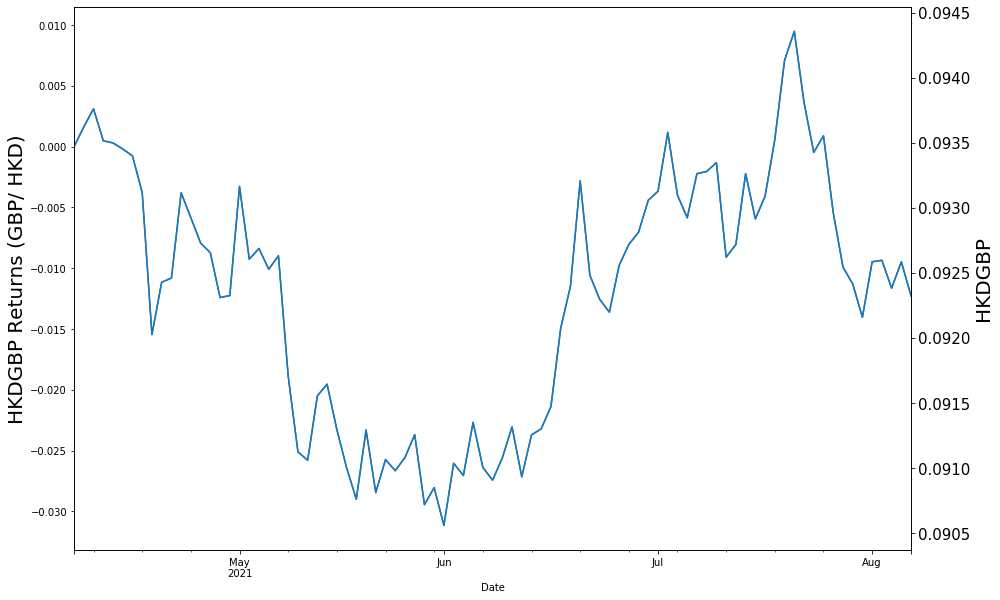

In [26]:
## Cumulative Forex Returns 
print(f"Current HKDGBP Returns (GBP/ HKD): {round(df_fx.HKDGBP.iloc[-1]/df_fx.HKDGBP.iloc[0]-1, 5)}")

fx_ret = ((df_fx.HKDGBP.pct_change(1).fillna(0)+1).cumprod() -1).plot(figsize=(15,10))
fx_ret.set_ylabel('HKDGBP Returns (GBP/ HKD)', fontsize=20)

fx_price = fx_ret.twinx()
df_fx.HKDGBP.plot(ax=fx_price)
fx_price.set_ylabel('HKDGBP', fontsize=20)


_ =plt.yticks(fontsize=15)

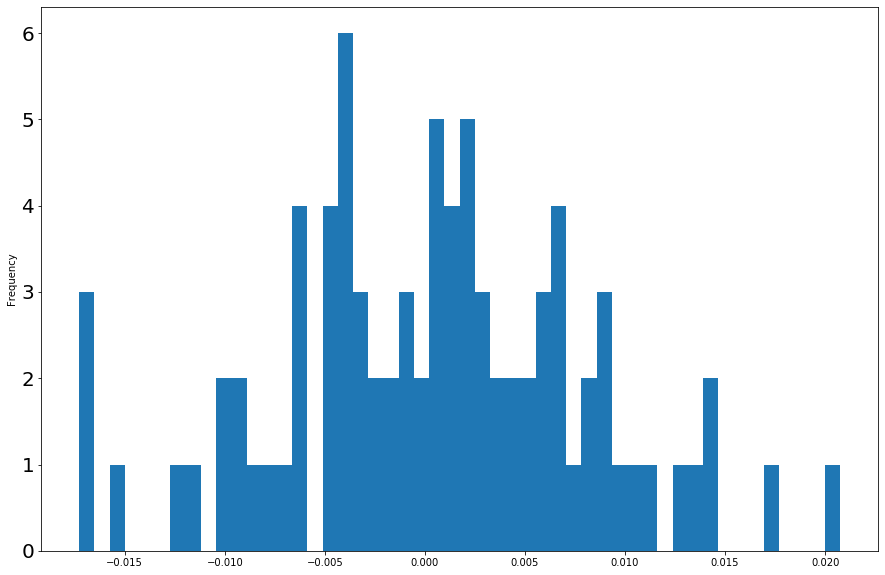

In [28]:
dist_ret = port_val['gbp_val'].pct_change().plot.hist(figsize=(15,10), bins=50)
etfs_ret_ax.set_ylabel('Frequency', fontsize=20)
_= plt.yticks(fontsize=20)